<font color=darkblue> 
Bonus Jupyter Notebook to go with 
    
**Model mis-specification and bias in the least-squares algorithm:  Implications for linearized isotropic AVO** 
    
Henning Hoeber, CGG, September 2021, The Leading Edge.    

Code and worksheet come without any warranty.

*   References can be found in the paper and in the addendum I post on the github.

These are some additional notes to be read in conjunction with my September 2021 TLE paper \cite{Hoeber} on 
model misspecification and omitted variable bias (OVB). Having finished the paper, I started looking 
at the Ball et al. paper in Geophysics, from 2018 \cite{Ball}, on three-term AVO projections. (Better late 
than never; but apologies to the authors for not including this reference in my paper). 
It is easy to see how bias is also captured in the AVO projection operators, and here I show how. 

I run two examples.

A. I show that the two-term Shuey fit can be obtained via the three-term Shuey fit via the projection operator. I also show how the projection operator is linked to the bias weights I calculated in the paper.

B. I repeat the exercise but now linking two-term Shuey to three-term Fatti.

In [1]:
import numpy as np
np.set_printoptions(precision=5, suppress=False)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels import robust
#
plt.style.use('seaborn-whitegrid')
# Default sizes for figure labels
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams['axes.labelsize'] = 20
plt.rc('font',family='monospace')
# fontsize for annotations
fsann=16
# ylimit
pyl=-0.25
pym=0.025

In [2]:
## Class 3 AVO
vp1=2500
vp2=2880
vs1=1100
vs2=1810
rho1=2.35
rho2=1.99

In [3]:
def Rx(x1, x2):
    x  =0.5*(x1+x2)
    dx = x2-x1
    Rx = 0.5* dx/x
    return Rx
Rd  = Rx(rho1, rho2)
gamma = (vs1+vs2)/(vp1+vp2)
g2 = gamma**2
Rvp = Rx(vp1, vp2)
Rvs = Rx(vs1, vs2)
Rvsd = Rd + 2 * Rvs
# Note: you have to build RIp and RIs like this, otherwise the first order approximation
# may be violated!
RIp = Rvp + Rd
RIs = Rvs + Rd
###########################
#
# Shuey parameters
R0 = Rvp + Rd
G  = Rvp - 4 * gamma**2 * (Rd + 2*Rvs)
C  = Rvp 
# factor for quadratic term
D = (1/(4*gamma)) * (C-G)**2
###########################
def avoAK2T(avtheta, R0, G):
    Y_ARShuey2T = R0 + G*np.sin(avtheta)**2  
    return Y_ARShuey2T
def avoAK3T(avtheta, R0, G, C):
    Y_ARShuey3T = R0 + G*np.sin(avtheta)**2  + C * np.sin(avtheta)**2 * np.tan(avtheta)**2 
    return Y_ARShuey3T  
def avoAK4T(avtheta, R0, G, C):
    term4 = (1/(4*gamma)) * (C-G)**2 * (np.sin(avtheta))**2 * (np.cos(avtheta)) 
    Y_ARShuey4T = avoAK3T(avtheta, R0, G, C) + term4
    return Y_ARShuey4T   
###########################

In [4]:
############# angle range for the linear fitting
minangle = 0 
maxangle = 45
nangle   = 1*(maxangle - minangle + 1)
# X = the regressor 
Angles = np.linspace(minangle, maxangle, nangle)
# incidence angles
#Angles = np.arange(minangle, maxangle, 1)
# The incidence angle
theta1  = np.radians(Angles)
nobs = len(Angles) # number of observations
theta2 = np.arcsin(vp2/vp1*np.sin(theta1))
# Shuey is modelled with average angle, we need this in building the design matrix A later
avtheta = (theta1+theta2)/2.0
avangles = avtheta

In [5]:
### Setup data model as Zoeppritz model + noise
yclean = avoAK3T(avangles, R0, G, C)
# Gaussian noise of same variance at all angles
noiselevel = 0
# fed up seeing the same random noise, then remove the next line
np.random.seed(1)
mean = 0
std = noiselevel 
modelData = yclean + np.random.normal(mean, std, size=nobs)

# A. Create the 2-term Shuey fit from the 3-term Shuey fit 

In [6]:
print('Shuey model values')
print('%f'% R0, '%f'% G, '%f'% C)


Shuey model values
-0.012317 -0.403349 0.070632


In [7]:
import math
print('*********************3-term Shuey fit  ***************************')
###################
#
XX0S = np.ones(nobs)
XX1S = np.sin(avangles)**2  
XX2S = (np.tan(avangles))**2 - (np.sin(avangles))**2
# solve
A = np.column_stack( (XX0S, XX1S, XX2S))
AShuey3T = A
# solve
ATA    = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY    = np.dot(A.transpose(),modelData)
Model3tShuey  = np.dot(ATAINV,ATY) # SOLUTION
dataModelShuey3t=np.dot(A,Model3tShuey)
residualShuey3t = modelData - dataModelShuey3t
AGShuey3t = np.dot(ATAINV,A.transpose())
print('3 term fit range (incidence angle)', avtheta[0], math.degrees(theta1[nangle-1]))
print('Three-term fit result of Shuey AVO model to noise free 3-term model')
print('hatR0 = %f'% Model3tShuey[0])
print('hat G = %f'% Model3tShuey[1])
print('hat C= %f'% Model3tShuey[2])

*********************3-term Shuey fit  ***************************
3 term fit range (incidence angle) 0.0 45.0
Three-term fit result of Shuey AVO model to noise free 3-term model
hatR0 = -0.012317
hat G = -0.403349
hat C= 0.070632


In [8]:
#  Shuey 2 term 
A = np.column_stack( (XX0S, XX1S )) 
AShuey2t = A
# solve
ATA = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY = np.dot(A.transpose(),modelData)
AGShuey2t = np.dot(ATAINV,A.transpose())
ModelShuey2t = np.dot(ATAINV,ATY) # SOLUTION
dataModel2TShuey=np.dot(A,ModelShuey2t)
print('*****************************Shuey model')
print('%f'% R0, '%f'% G, '%f'% C)
print('*****************************Conventional Shuey 2-term fit')
print('R0 fit =%7.6f' % ModelShuey2t[0])
print('G fit=  %7.6f' % ModelShuey2t[1])

*****************************Shuey model
-0.012317 -0.403349 0.070632
*****************************Conventional Shuey 2-term fit
R0 fit =-0.017995
G fit=  -0.328611


## Calculate the bias weights


In [9]:
## Calculate the third term bias weights: covariance and dot product
vec = [np.dot(XX0S, XX2S), np.dot(XX1S,XX2S)]
biasR0G = np.dot(ATAINV, vec)
print(biasR0G) 

[-0.08038  1.05814]


In [10]:
## Show by hand that the bias weights re-create the 2-term fit [eq 5 addendum] from the 3-term fit
newR0Shuey2t = Model3tShuey[0] + biasR0G[0]*Model3tShuey[2]
newGShuey2t  = Model3tShuey[1] + biasR0G[1]*Model3tShuey[2]
print('%f'% newR0Shuey2t, '%f'% newGShuey2t)

-0.017995 -0.328611


## Build & apply the projection operator Shuey 2-term A^-g * Shuey 3t A

In [11]:
proj = np.dot(AGShuey2t,AShuey3T)
# Use projection operator to get 2 term Shuey from 3 term Shuey
shuey2termproj = np.dot(proj,Model3tShuey)
print('Projection matrix')
print(proj)
print('*****************Shuey model params from application of the 3-term projection')
print('R0 fit =%7.6f' % shuey2termproj[0])
print('G fit=  %7.6f' % shuey2termproj[1])

Projection matrix
[[ 1.00000e+00 -1.65007e-18 -8.03836e-02]
 [ 5.27356e-16  1.00000e+00  1.05814e+00]]
*****************Shuey model params from application of the 3-term projection
R0 fit =-0.017995
G fit=  -0.328611


Discussion: Notice how the projection matrix has a 2x2 unit matrix on the left

# B. Start with a 3-term Fatti and create the two-term Shuey

In [12]:
import math
print('*********************3-term Fatti fit  ***************************')
################################
print('3-term model params for Fatti are')
print('RIp = %f'% RIp)
print('RIs    = %f'% RIs)
print('Rd    = %f'% Rd)
###################
XX0F  = 1 + (np.tan(avtheta))**2
XX1F  = -8*g2*(np.sin(avtheta))**2
XX2F  = (np.tan(avtheta))**2 - 4*g2*(np.sin(avtheta))**2
#
# solve
A = np.column_stack( (XX0F, XX1F, XX2F))
AFatti3T = A
# solve
ATA    = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY    = np.dot(A.transpose(),modelData)
Model3tFatti  = np.dot(ATAINV,ATY) # SOLUTION
dataModelFatti3t=np.dot(A,Model3tFatti)
residualFatti3t = modelData - dataModelFatti3t
AGFatti3t = np.dot(ATAINV,A.transpose())
print('3 term fit range (incidence angle)', avtheta[0], math.degrees(theta1[nangle-1]))
print('Three-term fit result of Fatti AVO model to noise free 4-term Model')
print('hat RIp = %f'% Model3tFatti[0])
print('hat RIs = %f'% Model3tFatti[1])
print('hat Rd  = %f'% Model3tFatti[2])

*********************3-term Fatti fit  ***************************
3-term model params for Fatti are
RIp = -0.012317
RIs    = 0.161037
Rd    = -0.082949
3 term fit range (incidence angle) 0.0 45.0
Three-term fit result of Fatti AVO model to noise free 4-term Model
hat RIp = -0.012317
hat RIs = 0.161037
hat Rd  = 0.082949


## Next do a 2 term Shuey fit

In [13]:
#  Shuey 2 term 
A = np.column_stack( (XX0S, XX1S )) 
AShuey2t = A
# solve
ATA = np.dot(A.transpose(),A)
ATAINV = np.linalg.inv(ATA)
ATY = np.dot(A.transpose(),modelData)
AGShuey2t = np.dot(ATAINV,A.transpose())
ModelShuey2t = np.dot(ATAINV,ATY) # SOLUTION
dataModel2TShuey=np.dot(A,ModelShuey2t)
print('*****************************Shuey model')
print('%f'% R0, '%f'% G, '%f'% C)
print('*****************************Conventional Shuey 2-term fit')
print('R0 fit =%7.6f' % ModelShuey2t[0])
print('G fit=  %7.6f' % ModelShuey2t[1])

*****************************Shuey model
-0.012317 -0.403349 0.070632
*****************************Conventional Shuey 2-term fit
R0 fit =-0.017995
G fit=  -0.328611


## Build the projection operator Shuey 2-term A^-g * Fatti 3t A

In [14]:
proj = np.dot(AGShuey2t,AFatti3T)
# Use projection operator to get 2 term Shuey from 3 term Fatt
shuey2termproj = np.dot(proj,Model3tFatti)
print('Projection matrix')
print(proj)
print('*****************Shuey model params from application of the 3-term projection')
print('R0 fit =%7.6f' % shuey2termproj[0])
print('G fit=  %7.6f' % shuey2termproj[1])

Projection matrix
[[ 9.19616e-01  4.16036e-17 -8.03836e-02]
 [ 2.05814e+00 -2.34051e+00  8.87884e-01]]
*****************Shuey model params from application of the 3-term projection
R0 fit =-0.017995
G fit=  -0.328611


## Fit 2-term AVO to the synthetic from the 3 term Fatti fit

In [15]:
ATY = np.dot(AShuey2t.transpose(),dataModelFatti3t)
newModelShuey2t = np.dot(ATAINV,ATY) # SOLUTION
dataModel2TShuey=np.dot(A,newModelShuey2t)
print('*****************************Shuey 2-term fit of the synthetic from 3 term Fatti fitting')
print('R0 fit =%7.6f' % newModelShuey2t[0])
print('G fit=  %7.6f' % newModelShuey2t[1])

*****************************Shuey 2-term fit of the synthetic from 3 term Fatti fitting
R0 fit =-0.017995
G fit=  -0.328611


## Projection of the A-g 2t Shuey onto the model data from Fatti 3t should again give the same as the basic 2-term Shuey fit

In [16]:
tt=AGShuey2t.dot(dataModelFatti3t)
print('R0 fit =%7.6f' % tt[0])
print('G fit=  %7.6f' % tt[1])

R0 fit =-0.017995
G fit=  -0.328611


## Another way of saying this A^-g 2t Shuey projected onto the Fatti 3t residual is zero: the Fatti residual is in the nullspace of the Shuey generalised inverse

In [17]:
AGShuey2t.dot(residualFatti3t)

array([ 1.32140e-16, -1.12816e-15])

## Test A1 = N2 A1

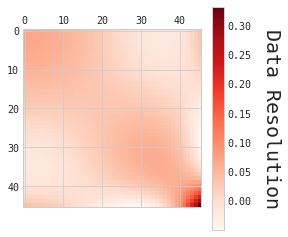

In [18]:
### Data Resolution matrix of 3-term Fatti
resFatti3t=AFatti3T.dot(AGFatti3t)
#fig, ax = plt.subplots()
plt.matshow(resFatti3t, cmap=plt.cm.Reds)
clb=plt.colorbar()
clb.set_label('Data Resolution', rotation=270, labelpad=+30)
plt.show()

In [19]:
# A-g Shuey NFatti
AGShuey2t.dot(resFatti3t) - AGShuey2t

array([[ 7.63278e-17,  7.63278e-17,  7.63278e-17,  8.32667e-17,
         7.63278e-17,  4.16334e-17,  9.02056e-17,  4.85723e-17,
         5.55112e-17,  8.32667e-17,  6.93889e-17,  8.32667e-17,
         6.24500e-17,  5.55112e-17,  5.55112e-17,  4.16334e-17,
         4.16334e-17,  4.85723e-17,  2.77556e-17,  4.85723e-17,
         4.16334e-17,  3.81639e-17,  3.46945e-17,  5.55112e-17,
         2.77556e-17,  4.16334e-17,  4.16334e-17,  3.46945e-17,
         3.46945e-17,  2.94903e-17,  3.46945e-17,  1.38778e-17,
         2.34188e-17,  1.17094e-17,  3.25261e-18, -1.08420e-18,
         1.30104e-17,  9.54098e-18, -6.93889e-18,  1.21431e-17,
        -3.46945e-18,  0.00000e+00, -3.46945e-18, -1.73472e-17,
        -2.08167e-17, -1.73472e-17],
       [-2.22045e-16, -2.22045e-16, -1.38778e-16, -1.66533e-16,
        -1.66533e-16, -2.49800e-16, -1.11022e-16, -1.66533e-16,
        -1.80411e-16, -2.35922e-16, -1.80411e-16, -1.66533e-16,
        -1.66533e-16, -2.08167e-16, -1.94289e-16, -1.52656e-16,
   

## Can also write this as N 2t Shuey = N 2t Shuey N 3t Fatti
### N is the data resolution matrix

In [20]:
resShuey2t=AShuey2t.dot(AGShuey2t)
resShuey2t - resShuey2t.dot(resFatti3t)

array([[-7.63278e-17, -7.63278e-17, -7.63278e-17, ...,  1.73472e-17,
         2.08167e-17,  1.73472e-17],
       [-6.93889e-17, -2.77556e-17, -8.32667e-17, ...,  1.73472e-17,
         2.08167e-17,  1.38778e-17],
       [-6.93889e-17, -4.85723e-17, -6.24500e-17, ...,  1.73472e-17,
         2.42861e-17,  1.73472e-17],
       ...,
       [ 2.77556e-17,  6.93889e-17,  3.46945e-18, ...,  1.24900e-16,
         8.32667e-17,  1.24900e-16],
       [ 3.46945e-17,  6.59195e-17,  1.04083e-17, ...,  1.24900e-16,
         9.71445e-17,  1.11022e-16],
       [ 5.55112e-17,  6.93889e-17,  3.46945e-18, ...,  1.24900e-16,
         9.71445e-17,  1.24900e-16]])